<a href="https://colab.research.google.com/github/DarioMameli/DL_Assignments/blob/main/DL_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

Firstly let's import all the necessary packages and update them.

Also check the type of runtime environment.

In [1]:
!pip install keras --upgrade --quiet
!pip install keras-tuner --upgrade

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras
from keras import regularizers
import matplotlib.gridspec as gridspec
from keras.datasets import fashion_mnist
from keras.layers import Dense, Flatten
from keras.models import Sequential
from keras.utils import to_categorical
import keras_tuner as kt

from dl_utils import plot_history

In [3]:
print(tf.__version__)
print(keras.__version__)

2.15.0
3.0.5


In [4]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Load data

In [5]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
print(X_train.shape)

(60000, 28, 28)


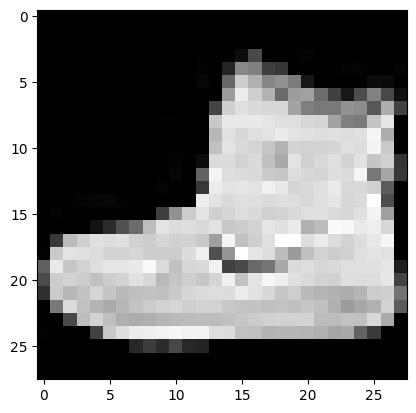

Label = 9


In [6]:
# Show an instance
plt.imshow(X_train[0], cmap="gray")
plt.show()
print("Label =", y_train[0])

In [7]:
# Input data preprocessing
print(np.min(X_train), np.max(X_train))
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

X_train /= 255
X_test /= 255

print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

0 255
60000 train samples
10000 test samples


In [8]:
# Labels preprocessing
print(np.min(y_train), np.max(y_train))
num_classes = 10

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print("First label is now = ", y_train[0])

0 9
First label is now =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


# Build the model
We use a simple fully connected network here using 8 hidden neurons, followed by another layer of 8 hidden neurons, and finally our output layer. We use the ReLU activation function, except for the output, where we apply a softmax activation as we're doing a multiclass classification here.


In [9]:
def MLPModel(num_classes):
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28)))
    model.add(Dense(8, activation="relu"))
    model.add(Dense(8, activation="relu"))
    model.add(Dense(num_classes, activation="softmax"))
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [10]:
model = MLPModel(num_classes)
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │           6,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │              90 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,442 (25.16 KB)

 Trainable params: 6,442 (25.16 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)
    print(layer.get_config())
    print()

0 flatten
{'name': 'flatten', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last'}

1 dense
{'name': 'dense', 'trainable': True, 'dtype': 'float32', 'units': 8, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}

2 dense_1
{'name': 'dense_1', 'trainable': True, 'dtype': 'float32', 'units': 8, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer

In [12]:
class MyMLPModel(kt.HyperModel):
  # Sets up the hyperparameters and calls the building model function
  def build(self, hp):
        model = self.build_MLP(hp)
        return model

  # Sets up the hyperparameters and calls the building model function
  def build_MLP(self, hp):
      # Tune the number of units for the Dense layers
      hp_units1 = hp.Int('units', min_value=32, max_value=512, step=32)
      hp_units2 = hp.Int('units', min_value=32, max_value=512, step=32)

      # Choose the activation function for the Dense layers
      hp_activation = hp.Choice("activation", ["relu", "tanh"])

      # Tune the learning rate for the optimizer
      hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

      # call existing model-building code with the hyperparameter values.
      model = self.build_MLP_hp(
          hp_units1=hp_units1, hp_units2=hp_units2, hp_activation=hp_activation,
          hp_learning_rate=hp_learning_rate
      )
      return model

  # Builds the actual model
  def build_MLP_hp(self, hp_units1, hp_units2, hp_activation, hp_learning_rate):
      model = Sequential()
      model.add(Flatten(input_shape=(28, 28)))
      model.add(Dense(units=hp_units1, activation=hp_activation))
      model.add(Dense(units=hp_units2, activation=hp_activation))
      model.add(Dense(10, activation="softmax"))
      model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                    loss="categorical_crossentropy", metrics=["accuracy"])
      return model

  def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [16, 32, 64, 128, 256]),
            **kwargs,
        )

In [13]:
tuner = kt.Hyperband(MyMLPModel(),
                     objective='val_accuracy',
                     max_epochs=10)
tuner.search_space_summary()

Reloading Tuner from ./untitled_project/tuner0.json
Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


# Training


Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.3265 - loss: 1.6853 - val_accuracy: 0.7445 - val_loss: 0.7980
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7693 - loss: 0.7012 - val_accuracy: 0.7933 - val_loss: 0.5957
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8079 - loss: 0.5526 - val_accuracy: 0.8228 - val_loss: 0.5186
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8225 - loss: 0.5094 - val_accuracy: 0.8152 - val_loss: 0.5161
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8327 - loss: 0.4819 - val_accuracy: 0.8278 - val_loss: 0.4892


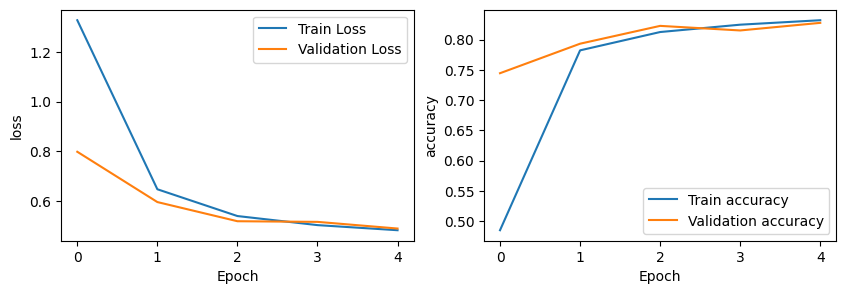

In [14]:
# Basic training

batch_size = 128
epochs = 5

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.2)
plot_history(history)

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.7747 - loss: 0.6220 - val_accuracy: 0.8582 - val_loss: 0.3843
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8618 - loss: 0.3734 - val_accuracy: 0.8622 - val_loss: 0.3762
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8788 - loss: 0.3309 - val_accuracy: 0.8768 - val_loss: 0.3482
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8875 - loss: 0.2985 - val_accuracy: 0.8739 - val_loss: 0.3451
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8940 - loss: 0.2818 - val_accuracy: 0.8873 - val_loss: 0.3214
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9009 - loss: 0.2663 - val_accuracy: 0.8854 - val_loss: 0.3172
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9035 - loss: 0.2597 - val_accuracy: 0.8901 - val_loss: 0.3071
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9124 - loss: 0.2343 

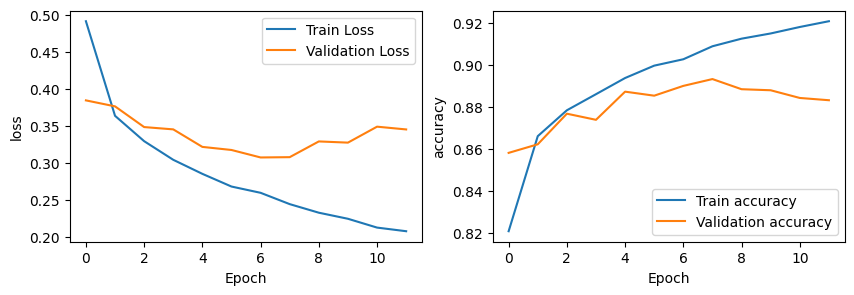

Best epoch: 8


In [15]:
# KerasTuner training

# Early stop to prevent overfitting
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(X_train, y_train, epochs=5, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters and train it on the data for 20 epochs
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, epochs=20, validation_split=0.2, callbacks=[stop_early])

plot_history(history)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [16]:
print(model.layers[1].get_weights()[0].shape)  # weights
print(model.layers[1].get_weights()[1].shape)  # bias

(784, 8)
(8,)


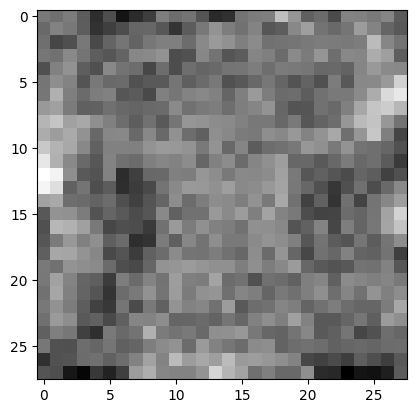

In [17]:
# Visualizing weights of first dense layer
rs = model.layers[1].get_weights()[0][:, 0].reshape(28, 28)
plt.imshow(rs, cmap="gray")
plt.show()

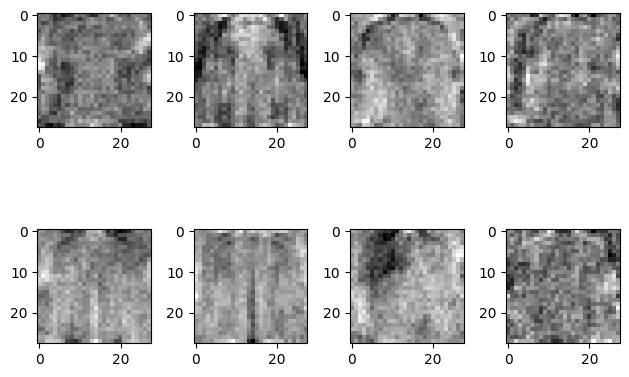

In [18]:
# Show all 8 weights of the first dense layer
gs = gridspec.GridSpec(2, 4)
for n in range(8):
    rs = model.layers[1].get_weights()[0][:, n].reshape(28, 28)
    ax = plt.subplot(gs[n])
    ax.imshow(rs, cmap="gray")
plt.tight_layout()
plt.show()

# Evaluation

In [19]:
score = model.evaluate(X_test, y_test, verbose=0)

print("Basic model")
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Basic model
Test loss: 0.5131823420524597
Test accuracy: 0.8198999762535095


In [20]:
score = best_model.evaluate(X_test, y_test, verbose=0)

print("Keras Tuner model")
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Keras Tuner model
Test loss: 0.36331143975257874
Test accuracy: 0.8756999969482422


In [21]:
scores = model.predict(np.array([X_train[0]]))

print(scores)
print("Predicted label = ", np.argmax(scores))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
[[6.1288064e-10 1.7841976e-09 9.7471170e-11 8.2993716e-12 3.2561402e-17
  3.0525515e-03 3.3799858e-09 4.2862180e-03 1.0146807e-05 9.9265105e-01]]
Predicted label =  9
